# Mean-field Variational Inference for a Mixture of Gaussians

We implement mean-field variational inference for detecting the centers of a specified number of clusters based on a Gaussian mixture model. Work done by Rachel Levanger for Fall 2016 Foundation of Graphical Models at Columbia University, HW #3.

In [1]:
import os
import math
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
from scipy import misc
from scipy import spatial

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Some functions we'll use later

In [2]:
# Randomly choose num_clusters points according to N(0,variance*I) distribution in R^dims
def get_cluster_means(num_clusters, variance, dims):
    multi_v_sample = np.random.multivariate_normal(np.zeros(dims), variance*np.identity(dims) , num_clusters).T
    return multi_v_sample

## Import the dataset

We use the feature vectors generated from the topological data from the mid-plane temperature field of Rayleigh-Benard Convection.

In [3]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
sFeatures = 'feature_vectors_lyap/%06d.txt'
sTemperature = 'bmps/%06d.bmp'



In [95]:
allFeatures = []

for idx in range(0, 3500, 5):
    if os.path.exists(sDir + "/" + (sFeatures % idx)):
        features = pd.read_csv(sDir + "/" + (sFeatures % idx), sep=' ', header=None)
        features = np.asarray(features)
        features = np.hstack((np.ones((features.shape[0],1))*idx, features))
        if len(allFeatures) == 0:
            allFeatures = features
        else:
            allFeatures = np.append(allFeatures, features, axis=0)

print allFeatures.shape
print allFeatures[0,:]
np.set_printoptions(suppress=True)
print np.amax(allFeatures,axis=0)

(2300, 105)
[   5.    5.  143.  284.    6.   61.  117.    0.  171.    3.   14.   11.
   14.   12.    6.    0.    0.    0.    0.    0.    0.   13.    7.    3.
    0.    2.    4.   10.    1.    2.    3.    3.    9.    0.    0.    0.
    0.    0.    6.   38.   20.    0.    0.    0.    0.   26.    6.    2.
    2.    0.    1.    2.    3.    0.    0.    0.   15.   22.    7.    3.
    2.    2.    8.   16.   22.    3.   22.   61.   36.    0.    0.    0.
    0.    0.    0.   16.   66.   33.   27.   32.   41.    0.    0.    0.
    0.    0.    0.    0.  105.  102.    9.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    4.   18.   18.   31.  148.]
[ 3495.  3495.   389.   388.    18.   319.   255.     0.   238.    66.
    64.    60.    64.    61.    54.    64.    63.    65.    65.    66.
    66.    67.    63.    56.    54.    63.    56.    63.    57.    64.
    61.    52.    67.    67.    67.    64.    58.    59.    64.    67.
    65.    48.    46.    56.    67.    68.    64.    66.    59. 

In [96]:
# Filter by lyapunov value

d = 6
myFeatures = allFeatures[(allFeatures[:,d]>=200), :]

# myFeatures = allFeatures

myFeatures = np.hstack((myFeatures[:, [1,2,3]], myFeatures[:,8:]))

X = myFeatures
X = X[:,3:]
X[:,0] = X[:,0]
print myFeatures[0,:]
print X[0,:]
# X = myFeatures[:, featureStart:]
# X = np.hstack((X[:,0:32],X[:,32:]/1.))

print X.shape

[   5.  151.  311.  109.   10.   13.   11.   11.   15.    3.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    2.   19.   45.    0.    0.
    0.    0.    0.    0.   55.    5.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    5.    6.    0.    0.    1.    0.    4.   24.    1.
    1.    0.    1.   19.  131.   41.   12.   17.    1.    0.    0.    0.
    0.    0.    0.    5.    0.    0.    0.  111.   88.   16.    0.    0.
    0.    0.    0.    0.  105.  110.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.   24.   19.   20.   38.   51.   42.    7.    0.
    0.    0.    1.   12.]
[ 109.   10.   13.   11.   11.   15.    3.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    2.   19.   45.    0.    0.    0.    0.    0.
    0.   55.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    5.    6.    0.    0.    1.    0.    4.   24.    1.    1.    0.    1.
   19.  131.   41.   12.   17.    1.    0.    0.    0.    0.    0.    0.
    5.    0.    0.    0. 

In [97]:
N = X.shape[0]
dim = X.shape[1]

print X[0,:]
print X.shape


[ 109.   10.   13.   11.   11.   15.    3.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    2.   19.   45.    0.    0.    0.    0.    0.
    0.   55.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    5.    6.    0.    0.    1.    0.    4.   24.    1.    1.    0.    1.
   19.  131.   41.   12.   17.    1.    0.    0.    0.    0.    0.    0.
    5.    0.    0.    0.  111.   88.   16.    0.    0.    0.    0.    0.
    0.  105.  110.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.   24.   19.   20.   38.   51.   42.    7.    0.    0.    0.    1.
   12.]
(763, 97)


## Plot a projection of the data

(0.0, 250.0, 0.0, 70.0)

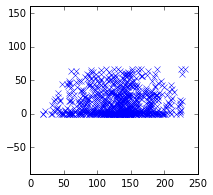

In [98]:
# Plot the means
plt.rcParams['figure.figsize'] = (3.0, 3.0)
plt.plot(X[:,0], X[:,1], 'x', markerfacecolor='blue')
plt.axis('equal')

## Implement mean-field variational inference

### Initialize the algorithm

In [99]:
# Set the minimum number of iterations
iterations = 20
K = 40

# Set the prior parameters
p_sigma = 1. # Variance of cluster of means

# Initialize the variational parameters
vi_m = np.zeros((iterations, K, dim)) # Cluster means, initialized to random points.
vi_m[0,:,:] = get_cluster_means(K, math.pow(p_sigma,2), dim).T + np.mean(X)
vi_m[0,:,:] = vi_m[0,:,:] + np.mean(X, axis=0)

vi_s_2 = np.zeros((iterations, K)) # Cluster variances, first initialized to one.
vi_s_2[0,:] = np.ones(K)

vi_phi = np.zeros((iterations, N, K)) # Assignment distributions, first initialized to categorical uniform
vi_phi[0,:,:] = np.ones((N,K))*(1./K)

# ELBO table
ELBO = np.zeros(iterations-1)

### Iterate the CAVI algorithm to get variational estimator for posterior

In [100]:
# Iterate the CAVI algorithm
for t in range(1,iterations):
    

    print t
    
    # Update the vi_phi: posterior assignment distributions
    for n in range(N):
        
        for k in range(K):
            log_sum_exp_argument = [np.dot(X[n],vi_m[t-1,j,:]) - (dim*vi_s_2[t-1,j] + np.dot(vi_m[t-1,j,:],vi_m[t-1,j,:]))/2. for j in range(K)]
            max_log_sum_exp = max(log_sum_exp_argument)
            log_sum_exp_sum = sum([math.exp(x - max_log_sum_exp) for x in log_sum_exp_argument])
            vi_phi_log = np.dot(X[n],vi_m[t-1,k,:]) - (dim*vi_s_2[t-1,k] + np.dot(vi_m[t-1,k],vi_m[t-1,k]))/2. - max_log_sum_exp - math.log(log_sum_exp_sum)
            vi_phi[t,n,k] = math.exp(vi_phi_log)
        
    # Update the vi_m and vi_s_2: posterior means and variances 
    vi_m[t,:,:] = vi_m[t-1,:,:]
    for k in range(K):
        
        sum_phi_x = np.zeros(dim)
        for n in range(N):
            sum_phi_x = sum_phi_x + vi_phi[t,n,k]*X[n]
        vi_m[t,k] = (sum_phi_x)/(p_sigma**(-2) + sum(vi_phi[t,:,k]))
        vi_s_2[t,k] = 1./(p_sigma**(-2) + sum(vi_phi[t,:,k]))
    
    # Update the ELBO
    for k in range(K):
        ELBO[t-1] = ELBO[t-1] + (-1./2.)*math.log(2*math.pi*(p_sigma**2)) - (np.dot(vi_m[t,k],vi_m[t,k]) + dim*vi_s_2[t,k])/(2.*p_sigma**2)
        ELBO[t-1] = ELBO[t-1] + (1./2.)*math.log(2*math.pi*vi_s_2[t,k]) + (1./2.)
    for n in range(N):
        ELBO[t-1] = ELBO[t-1] + math.log(1./K)
        ELBO[t-1] = ELBO[t-1] - sum([phi*math.log(phi) for phi in vi_phi[t,n,vi_phi[t,n,:] > 0]])
        ELBO[t-1] = ELBO[t-1] + sum([vi_phi[t,n,k]*((-1./2.)*math.log(2*math.pi) - np.dot(X[n],X[n])/2. + np.dot(X[n],vi_m[t,k]) - (dim*vi_s_2[t,k] + np.dot(vi_m[t,k],vi_m[t,k]))/2.) for k in range(K)])
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Plot the results!

In [101]:
# Get the expectations of the categories for each data point
z = np.zeros(N)

for n in range(N):
#     z[n] = np.random.multinomial(1,vi_phi[iterations-1,n,:]).nonzero()[0][0]
    z[n] = np.argmax(vi_phi[iterations-1,n,:])
    
z = z.astype(np.int)


(-50.0, 200.0, -10.0, 70.0)

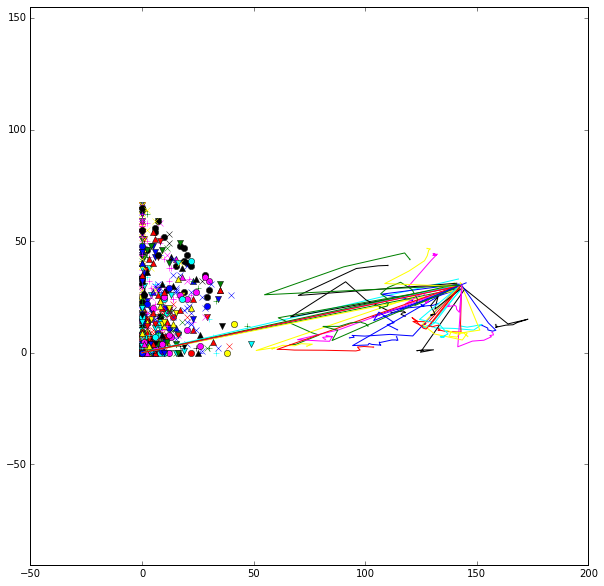

In [108]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

color=['cyan', 'blue', 'magenta', 'green', 'red', 'yellow', 'black']
marker=['o','x','+','v','^']


# Plot the datapoints with color chosen according to variational distribution
for n in range(N):
    ax.plot(X[n,2], X[n,1], 'x', marker=marker[z[n] % len(marker)], color=color[z[n] % len(color)])

# Plot the mean history for the variational inference algorithm
for k in range(K):
    ax.plot(vi_m[:,k,0],vi_m[:,k,1], color=color[k % len(color)])
    circle = matplotlib.patches.Ellipse([vi_m[iterations-1,k,0], vi_m[iterations-1,k,1]], 2.*np.sqrt(vi_s_2[iterations-1,k]), 2.*np.sqrt(vi_s_2[iterations-1,k]), alpha=0.25, color=color[k % len(color)])
    ax.add_patch(circle)

ax.axis('equal')


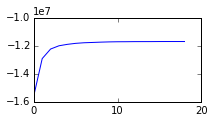

In [103]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.plot(ELBO[:])
plt.locator_params(nbins=3)
# plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/elbo.png' % (d), bbox_inches = 'tight', pad_inches = 0)


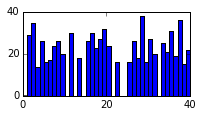

In [104]:
plt.rcParams['figure.figsize'] = (3.0, 1.5)
plt.hist(z, range(K+1))
plt.locator_params(nbins=3)
# plt.savefig('/Users/birdbrain/Documents/School/Columbia/GraphicalModels/Project/writeup/figures/%d/hist.png' % (d), bbox_inches = 'tight', pad_inches = 0)


Cluster 2


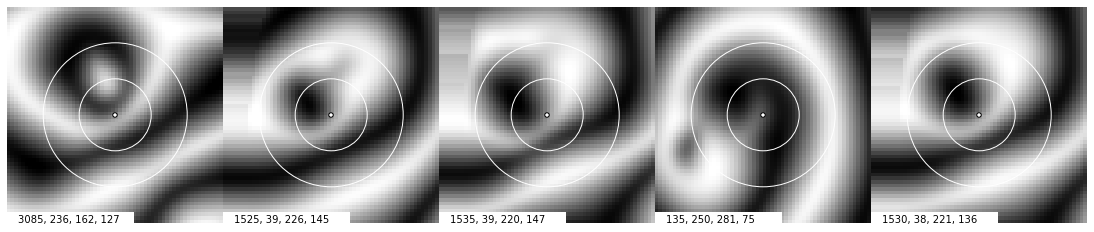

Cluster 3


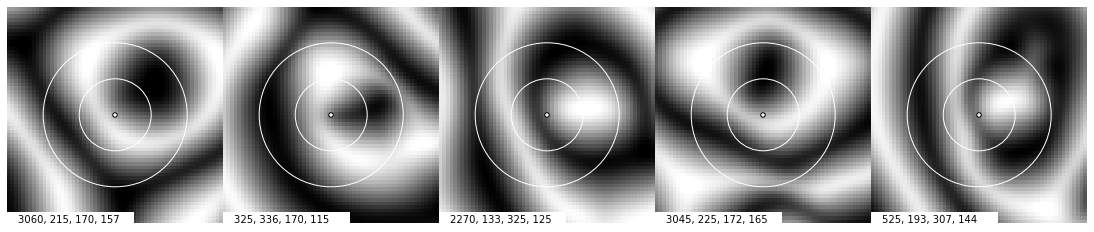

Cluster 4


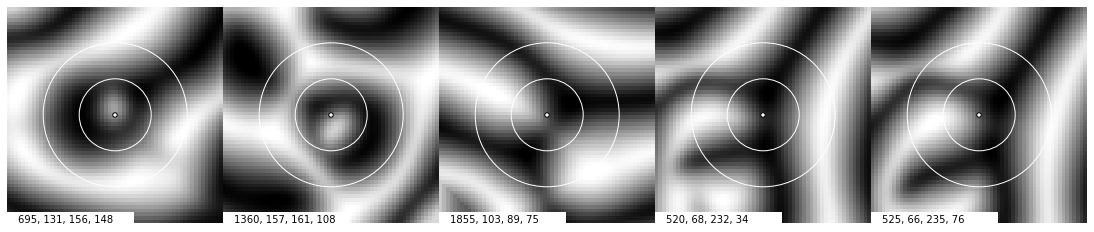

Cluster 5


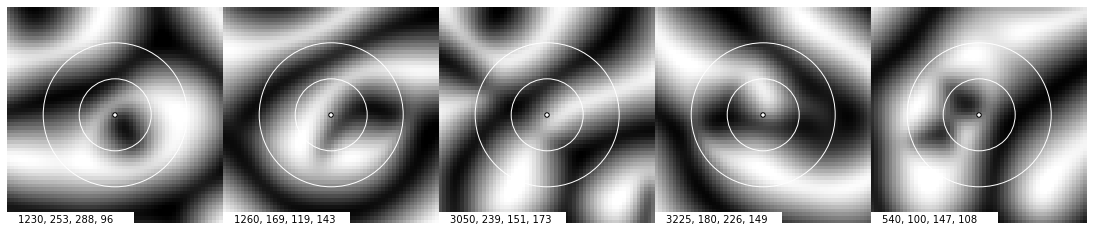

Cluster 6


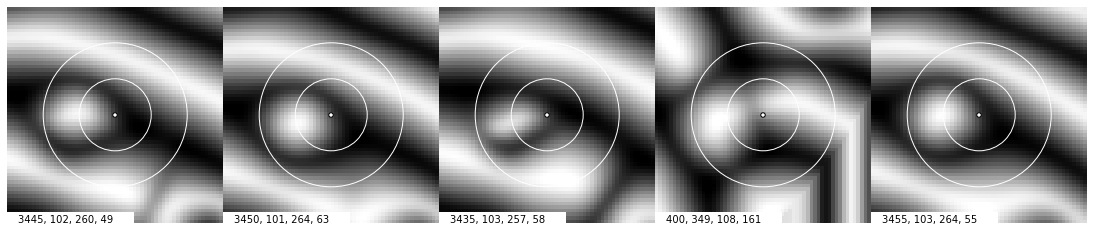

Cluster 7


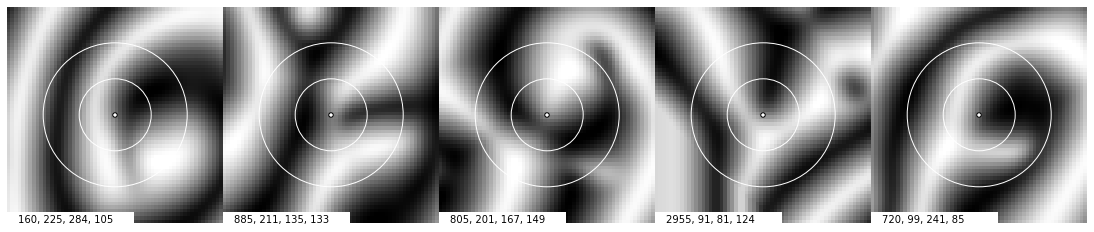

Cluster 8


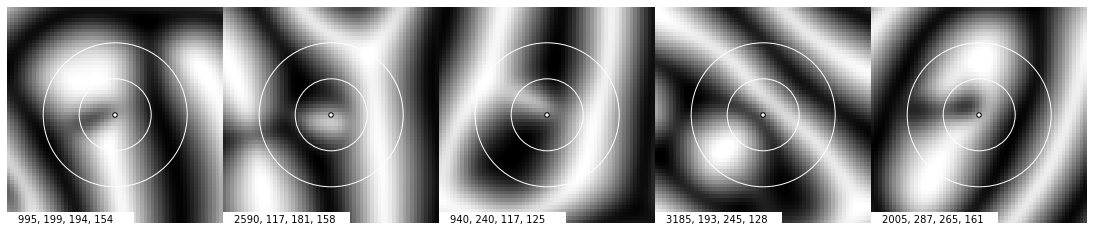

Cluster 9


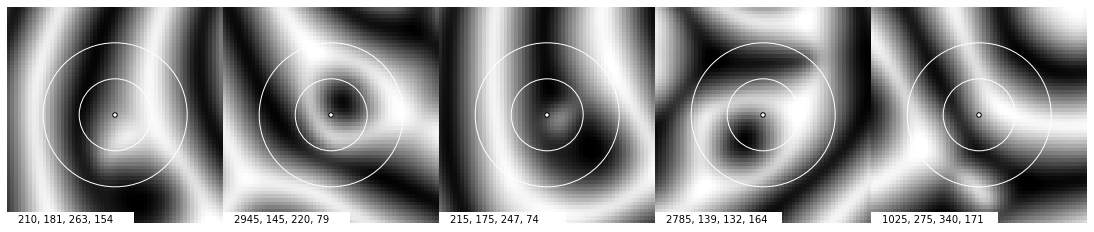

Cluster 10


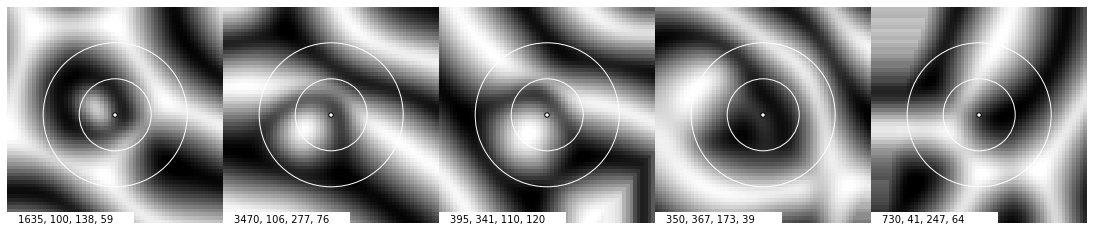

Cluster 12


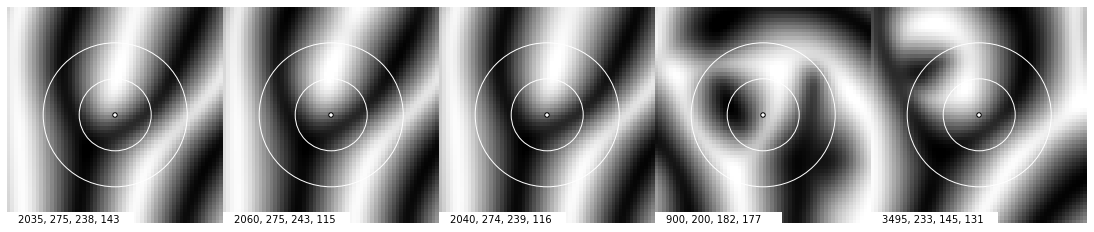

Cluster 14


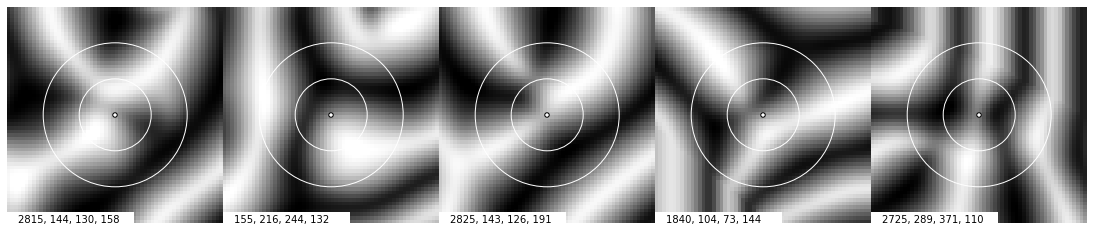

Cluster 16


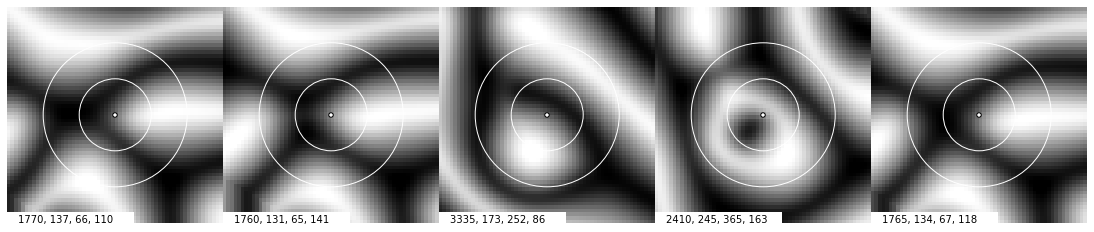

Cluster 17


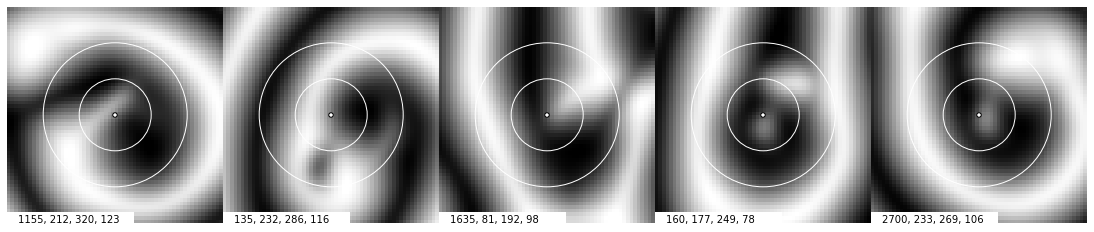

Cluster 18


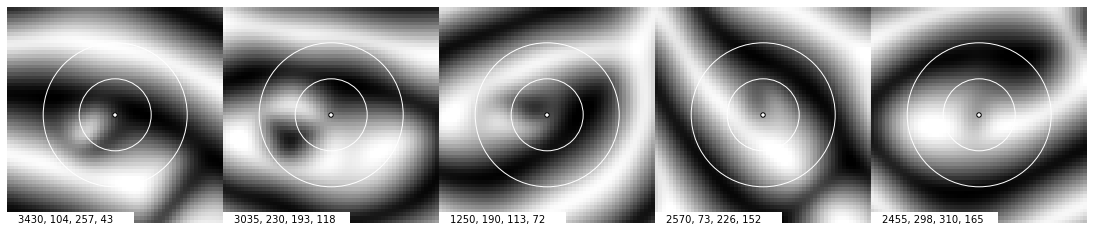

Cluster 19


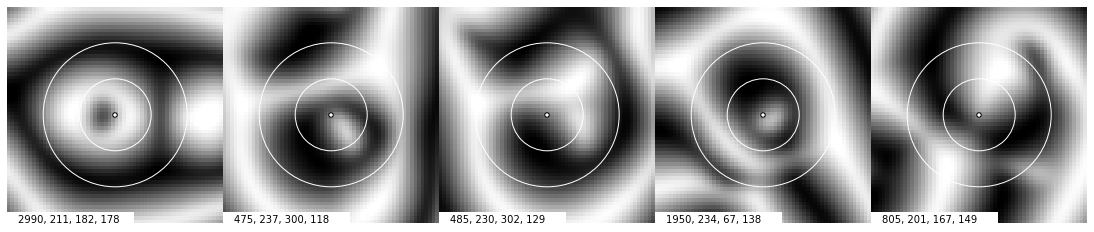

Cluster 20


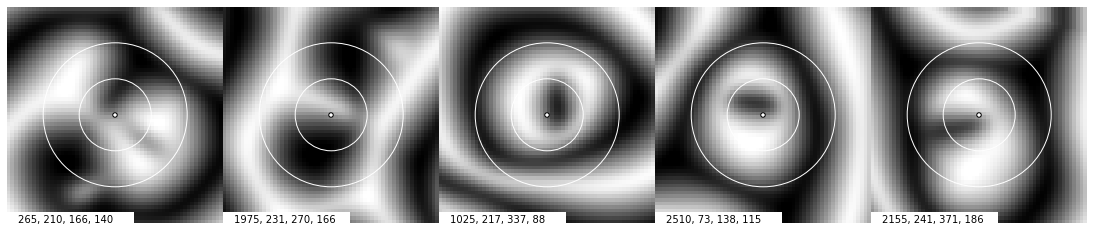

Cluster 21


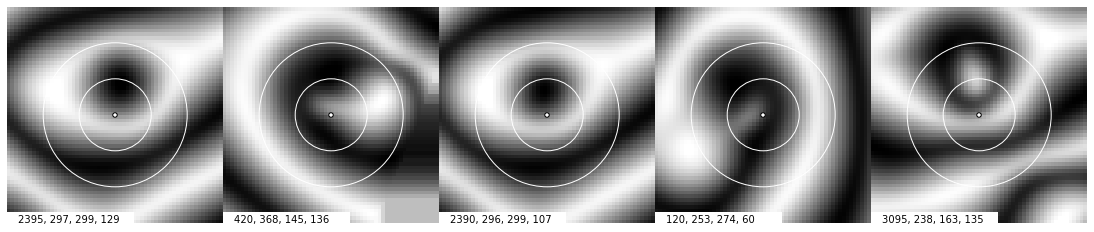

Cluster 23


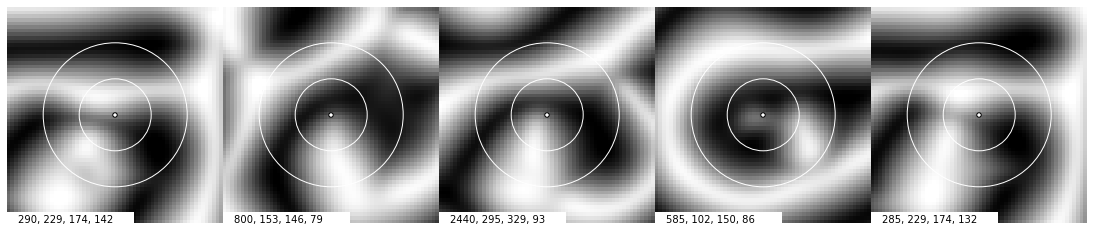

Cluster 26


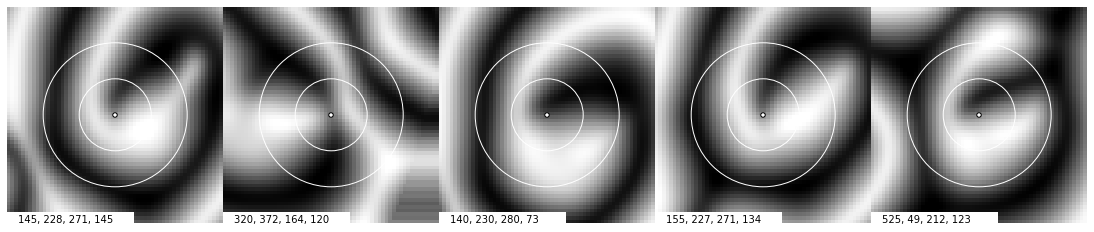

Cluster 27


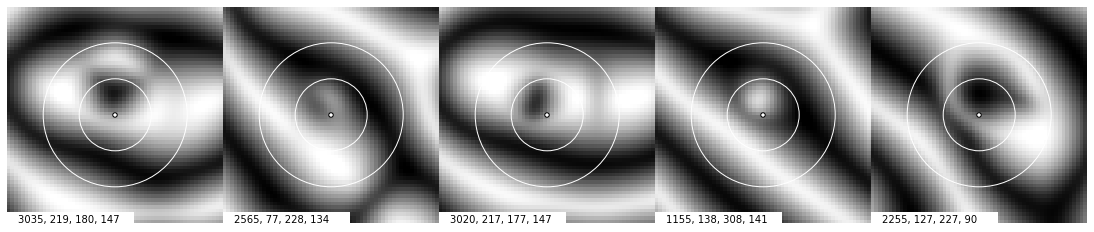

Cluster 28


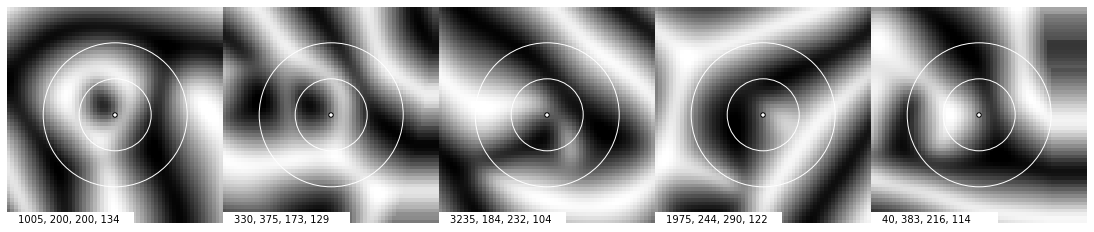

Cluster 29


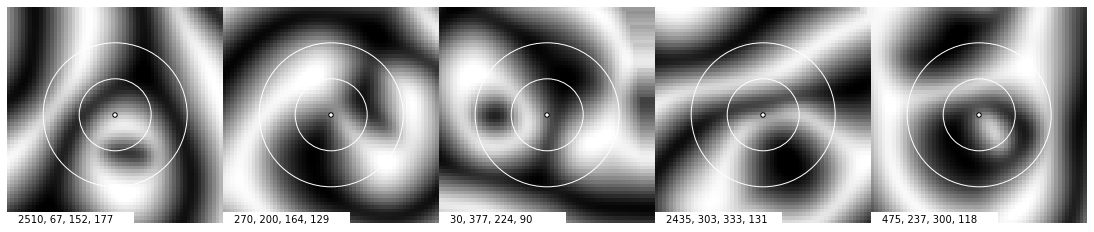

Cluster 30


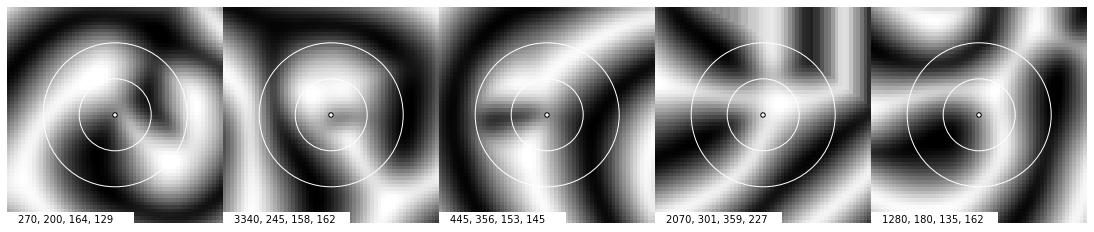

Cluster 31


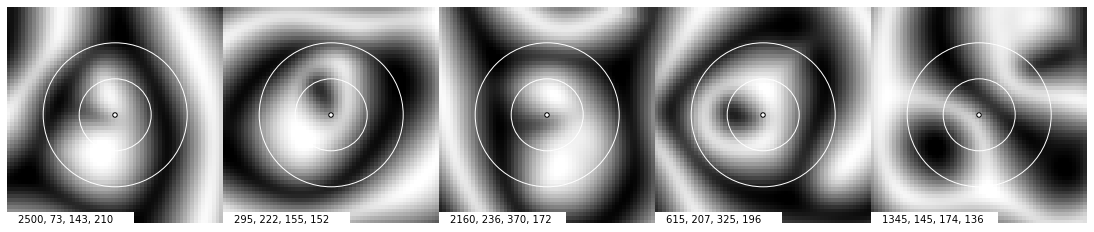

Cluster 32


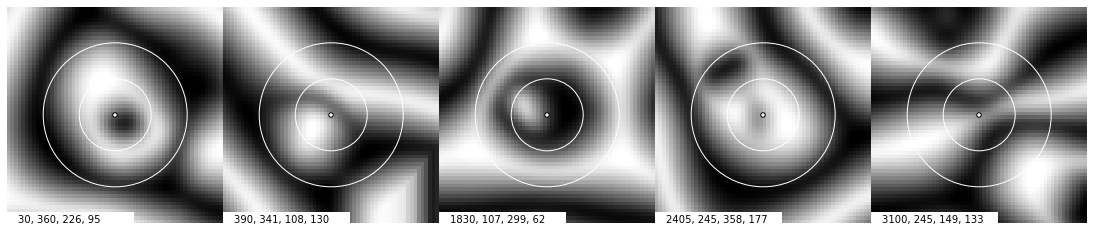

Cluster 34


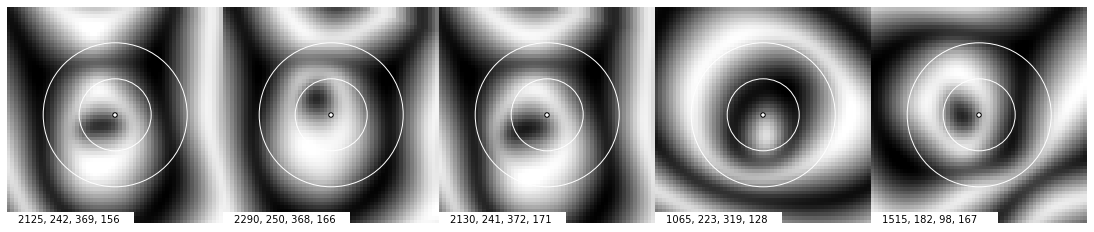

Cluster 35


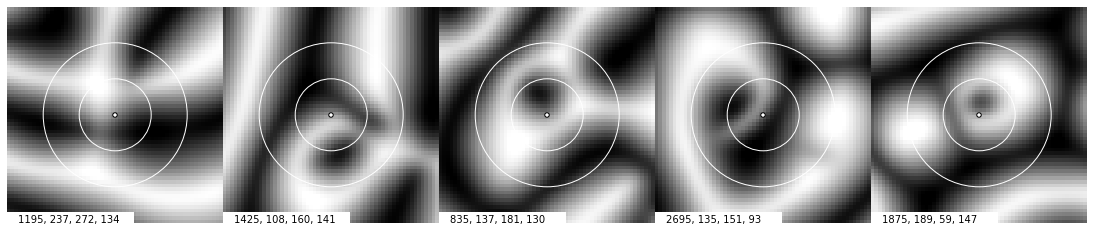

Cluster 36


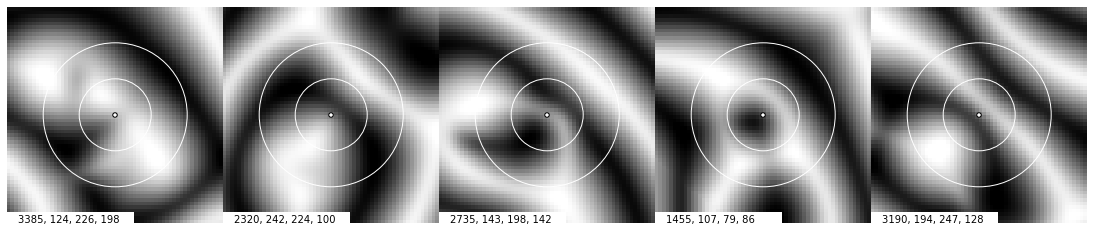

Cluster 37


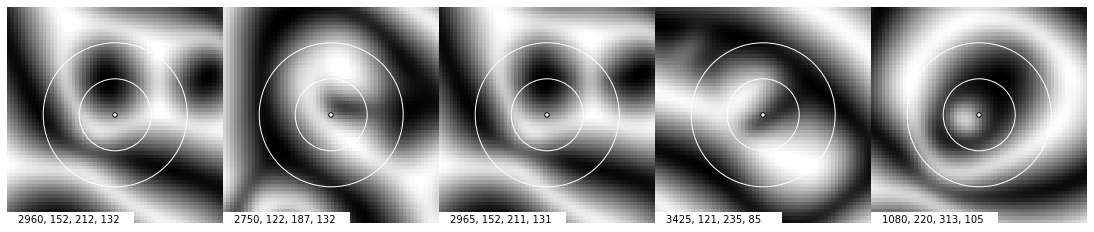

Cluster 38


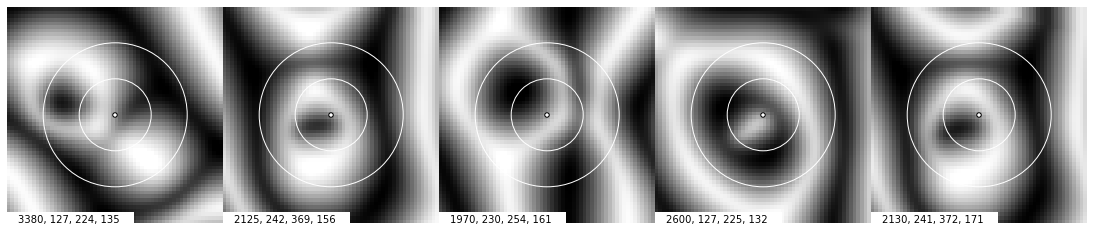

Cluster 39


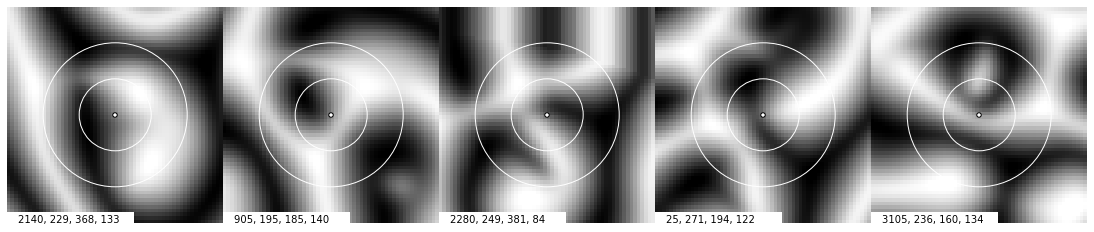

Cluster 40


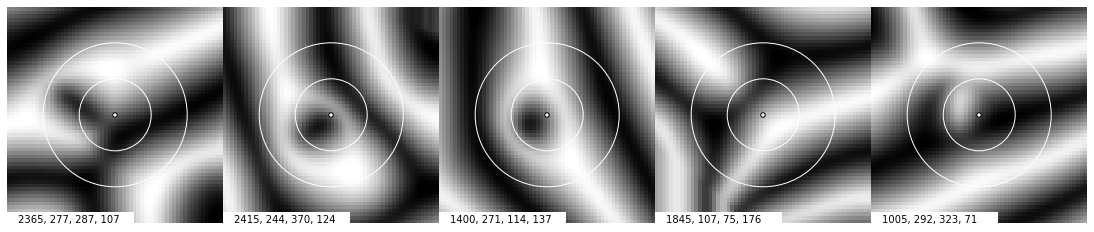

In [106]:
n = 5

plt.rcParams['figure.figsize'] = (15.0, 3.0)

for k in range(K):
    
    
    samples = myFeatures[np.argwhere(z==k),0:4]
    samples = samples.reshape((samples.shape[0],4))
        
    if len(samples) > 0:

        # Get n samples from cluster k that are closest to the mean of that cluster
        m_k = vi_m[-1,k]
        
#         if m_k[0] > 100:

#             print 'Cluster %d, LyapValue=%d' % (k+1, m_k[0])
        print 'Cluster %d' % (k+1)

        features = np.reshape(myFeatures[np.argwhere(z==k),3:], (myFeatures[np.argwhere(z==k),3:].shape[0], myFeatures[np.argwhere(z==k),3:].shape[2]))
        tree = spatial.KDTree(features)

        n_neighbors = min(n, features.shape[0])
        nn = tree.query(m_k, n_neighbors)

        for i in range(n_neighbors):

            if len(samples)==1:
                sample = nn[1]
            else:
                sample = nn[1][i]

            radius = 30
            tmp_radius = radius

            x = samples[sample,1]
            y = samples[sample,2]

            temp = misc.imread(sDir + "/" + (sTemperature % samples[sample,0]))

            plt.subplot(1,n,i)
#             fig = plt.figure()
            plt.set_cmap('gray')
            plt.pcolor(temp[(y-radius):(y+radius), (x-radius):(x+radius)].astype(np.int))
            plt.scatter(radius, radius, color='white', edgecolor='black')
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
            plt.margins(0,0)

#             plt.plot([tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], [tmp_radius, tmp_radius], color='white', lw=1)
#             plt.plot([tmp_radius, tmp_radius], [tmp_radius - tmp_radius/3., tmp_radius + tmp_radius/3.], color='white', lw=1)
            ax = plt.gca()
            circle1 = plt.Circle((tmp_radius, tmp_radius), 20, color='white', fill=False, lw=1)
            ax.add_artist(circle1)

            circle2 = plt.Circle((tmp_radius, tmp_radius), 10, color='white', fill=False, lw=1)
            ax.add_artist(circle2)

            plt.fill([0,radius+5,radius+5,0], [0,0,3,3], color='white')
            plt.annotate(', '.join([str(int(x)) for x in samples[sample,0:4]]),(3,0))

            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())

            plt.axis('off')

#             fig.tight_layout()
#             plt.savefig('/Users/birdbrain/Documents/School/Rutgers/Dissertation/figures/sdc/%d/%d_%d.png' % (d, k+1, i+1), bbox_inches = 'tight', pad_inches = 0)


        plt.show()